# Section 1: Business Understanding

There are thousands of place resources available on Airbnb. Some resources are personalized and provide travelers unique stays. For example, Airbnb can let travelers book entire houses that are not available in traditional hotel or will cost much more money. Airbnb not only provides guests more stay options, but also inspires hosts to rent their own resources and start their own business.

##### Here are some interesting questions I want to dig deep:
1. What’s the most popular listing type in Airbnb? How do the listing types impact the listing price?
2. What other factors will influence the listing price?
3. What’s the best time to visit Boston?
4. Can we use the limit data to estimate the listing price?

# Section 2: Data Understanding

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from decimal import *
from IPython import display

In [2]:
# read data
listings = pd.read_csv('/Users/feichen/Desktop/Boston airbnb dataset/listings.csv')
calendar = pd.read_csv('/Users/feichen/Desktop/Boston airbnb dataset/calendar.csv')

In [3]:
# check how many rows and columns for each data set
print("listing data set has " + str(listings.shape[0])  +" rows") #Provide the number of rows in the dataset
print("listing data set has " + str(listings.shape[1]) + " columns") #Provide the number of columns in the dataset
print("calendar data set has " + str(calendar.shape[0]) + " rows") #Provide the number of rows in the dataset
print("calendar data set has " + str(calendar.shape[1]) + " columns") #Provide the number of columns in the dataset

listing data set has 3043 rows
listing data set has 74 columns
calendar data set has 1048575 rows
calendar data set has 7 columns


# Section 3: Data Preparation

#### Check missing data

In [4]:
# Check columns contains more than 75% missing values
listings.columns[listings.isnull().mean() > 0.75]

Index(['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated'], dtype='object')

In [5]:
# Drop columns with high missing percentage
listings_new = listings.drop(columns=['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated'], axis =1)

In [6]:
# Check dataset still contatin missing values or not
calendar.columns[calendar.isnull().mean()>0]

Index(['price', 'adjusted_price'], dtype='object')

In [7]:
# price column will be our target column, we should remove null values
calendar = calendar.dropna(subset=['price']) # Drop NA ins column price

In [8]:
# drop rows with missing values
listings_new = listings_new.dropna() 

#### Working with data type 

In [9]:
# the original data set, price column includes $, we need remove dollar sign in listing data set in order to have numric calculation
import re
listings_new['price'] = listings_new.astype(str).price.apply(
    lambda value: re.sub(r'\$|,', '', value)
).astype(float)
listings_new['price'].head()

1     145.0
10    226.0
11     85.0
12    125.0
13     80.0
Name: price, dtype: float64

#### Remove outliers

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


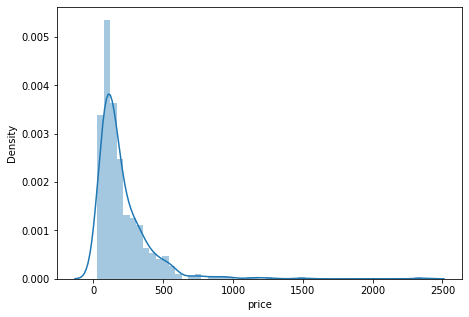

In [10]:
# check price distribution
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(listings_new['price'])
plt.show()

In [11]:
# remove outliers - find top 1% and bottom 1% boundary
upper_limit = listings_new['price'].quantile(0.99)
lower_limit = listings_new['price'].quantile(0.01)
print(upper_limit)
print(lower_limit)

942.8599999999993
41.68


In [12]:
# remove top 1% price and bottom 1% price
listings_new = listings_new[(listings_new['price'] <= 943) & (listings_new['price'] >= 42)]

In [13]:
listings_new.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1,5506,https://www.airbnb.com/rooms/5506,20210712150755,2021-07-12,**Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,...,4.89,4.52,4.78,Approved by the government,f,9,9,0,0,0.90
10,29765,https://www.airbnb.com/rooms/29765,20210712150755,2021-07-12,"Luxury suite, Moroccan furnishings","<b>The space</b><br />Romantic, comfortable, a...",Boston's oldest and most historic neighborhood...,https://a0.muscache.com/pictures/621420/77d899...,128280,https://www.airbnb.com/users/show/128280,...,4.97,4.79,4.96,STR-454024,f,1,1,0,0,0.72
11,40601,https://www.airbnb.com/rooms/40601,20210712150755,2021-07-12,Private room & bath - Jamaica Plain,Private bedroom and bathroom in my house in Ja...,Jamaica Plain is a diverse neighborhood of Bos...,https://a0.muscache.com/pictures/508984/678a92...,174986,https://www.airbnb.com/users/show/174986,...,4.94,4.91,4.94,STR-408632,f,1,0,1,0,0.72
12,45987,https://www.airbnb.com/rooms/45987,20210712150755,2021-07-12,Gorgeous Garden Studio Charlestown,"<b>The space</b><br />Lovely, private garden s...",Historical and safe.,https://a0.muscache.com/pictures/261758/678964...,205107,https://www.airbnb.com/users/show/205107,...,4.68,4.81,4.49,STR-409822,f,1,1,0,0,0.98
13,60029,https://www.airbnb.com/rooms/60029,20210712150755,2021-07-12,Room in geographical heart of Hub,"Small, sunny, private room in quiet but urban ...","Architecturally interesting, historic (Roxbury...",https://a0.muscache.com/pictures/3bf41756-488c...,255183,https://www.airbnb.com/users/show/255183,...,4.91,4.13,4.62,STR-415714,f,5,1,4,0,1.26


# Key factors affect airbnb listing price

### Q1: What’s the most popular listing type in Airbnb? How do the listing types impact the listing price?

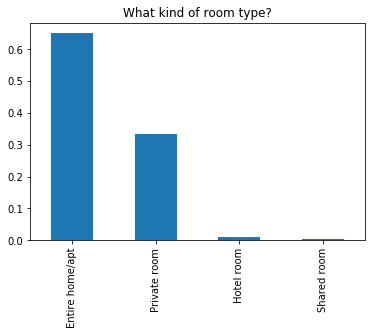

In [14]:
common_room_type = listings_new["room_type"].value_counts() 
(common_room_type/common_room_type.sum()).plot(kind="bar");
plt.title("What kind of room type?");

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '')

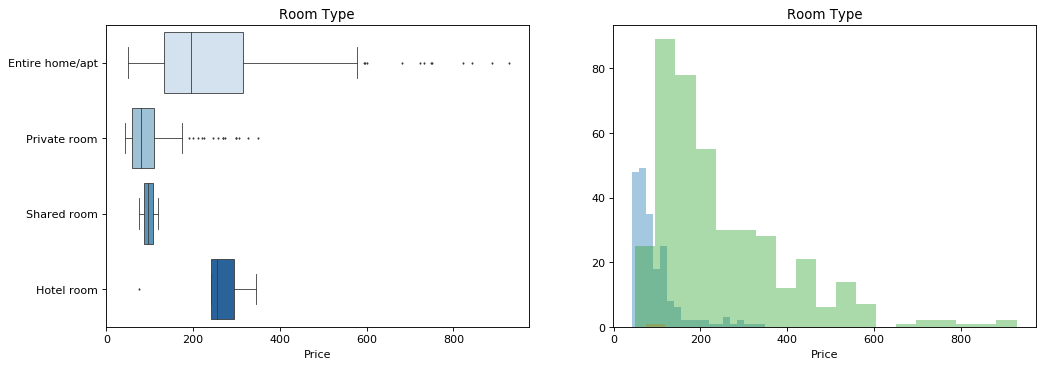

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=80)
sns.boxplot(x='price', y='room_type', fliersize=1, linewidth=0.75,
            data=listings_new, palette='Blues',ax=axs[0])
axs[0].set_title('Room Type')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('')

sns.distplot(listings_new[listings_new.room_type == 'Private room']['price'],ax=axs[1],kde=False)
sns.distplot(listings_new[listings_new.room_type == 'Shared room']['price'],ax=axs[1],kde=False)
sns.distplot(listings_new[listings_new.room_type == 'Entire home/apt']['price'],ax=axs[1],kde=False)

axs[1].set_title('Room Type')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('')
#plt.savefig('room_price.png', dpi=300, bbox_inches='tight')

The hotel room has a higher and comparatively short box plot. This suggests hotel room has a high-level price in Airbnb. The entire home has comparatively tall box plot and also much more listing resources. This suggests entire home has a big price difference regarding every single room resource and the entire home/apt is the most popular resource in Airbnb

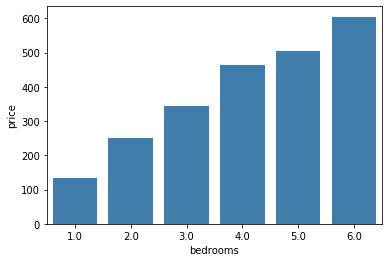

In [16]:
bedrooms = listings_new.groupby('bedrooms').agg({'price': 'mean'}).reset_index()
sns.barplot(
    x='bedrooms', y='price',
    data=bedrooms,
    orient='v',
    color='#2F7FBC'
)
#plt.savefig('bedrooms_price.png', dpi=300, bbox_inches='tight')

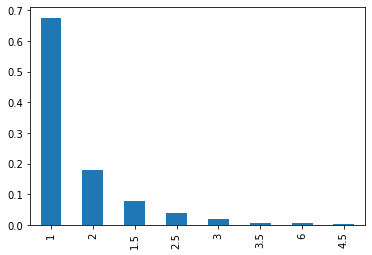

In [17]:
listings_new["bathrooms_text_number"] = listings_new["bathrooms_text"].str.split(" ").str[0]
bath = listings_new['bathrooms_text_number'].value_counts()
(bath/bath.sum()).plot(kind='bar', legend=None)

[Text(0, 0.5, 'number of bathrooms'), Text(0.5, 0, 'price')]

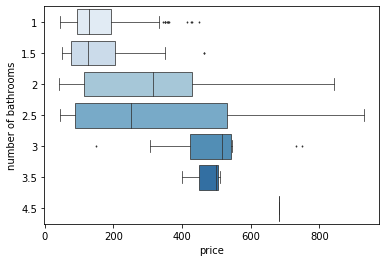

In [18]:
sns.boxplot(x='price', y='bathrooms_text_number', fliersize=1, linewidth=0.75,
            data=listings_new, palette='Blues',order = ["1","1.5","2","2.5","3","3.5","4.5"]).set(xlabel='price', ylabel='number of bathrooms')
# plt.savefig('bathroom_price_2.png', dpi=300, bbox_inches='tight')

From the histogram, we can clearly see that the number of bedrooms will impact the listing price, and the more bedrooms the place resources has, the higher price the homeowner can command. Similarly, the number of bathrooms has a positive impact on listing price. 

### Q2: What other factors will influence the listing price? will instant booking influence listing price?

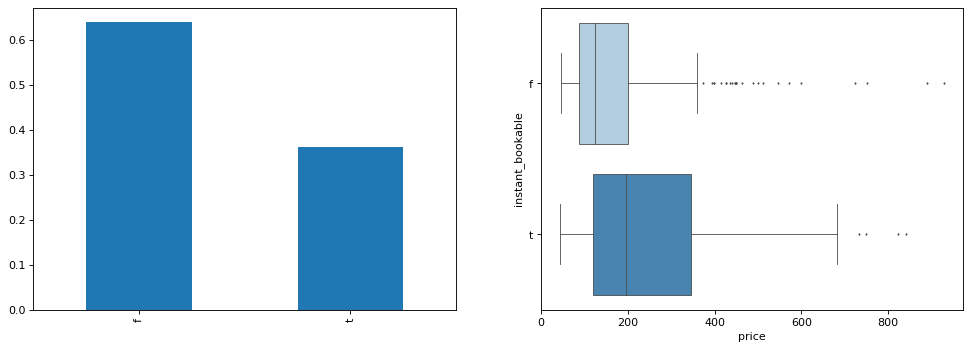

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=80)

instant_book = listings_new['instant_bookable'].value_counts()
(instant_book/instant_book.sum()).plot(kind='bar', legend=None,ax=axs[0])

sns.boxplot(x='price', y='instant_bookable', fliersize=1, linewidth=0.75,
            data=listings_new, palette='Blues',ax=axs[1])
#plt.savefig('instant_booking.png', dpi=300, bbox_inches='tight')

According to the below charts, more than half of the listing homes are not allowed instant bookings. But instant booking feature has slightly influence on listing price. The homes are allow to instant booking can set a higher price on average.

### Will neighborhood influence listing price?

In [20]:
# get average price for each neighbourhood
new = listings_new.groupby(by=["neighbourhood_cleansed"])["price"].mean().sort_values(ascending=False).reset_index()
new.head()

,neighbourhood_cleansed,price
0,Fenway,316.800000
1,West End,308.400000
2,Chinatown,302.666667
3,Downtown,292.049180
4,Beacon Hill,263.000000


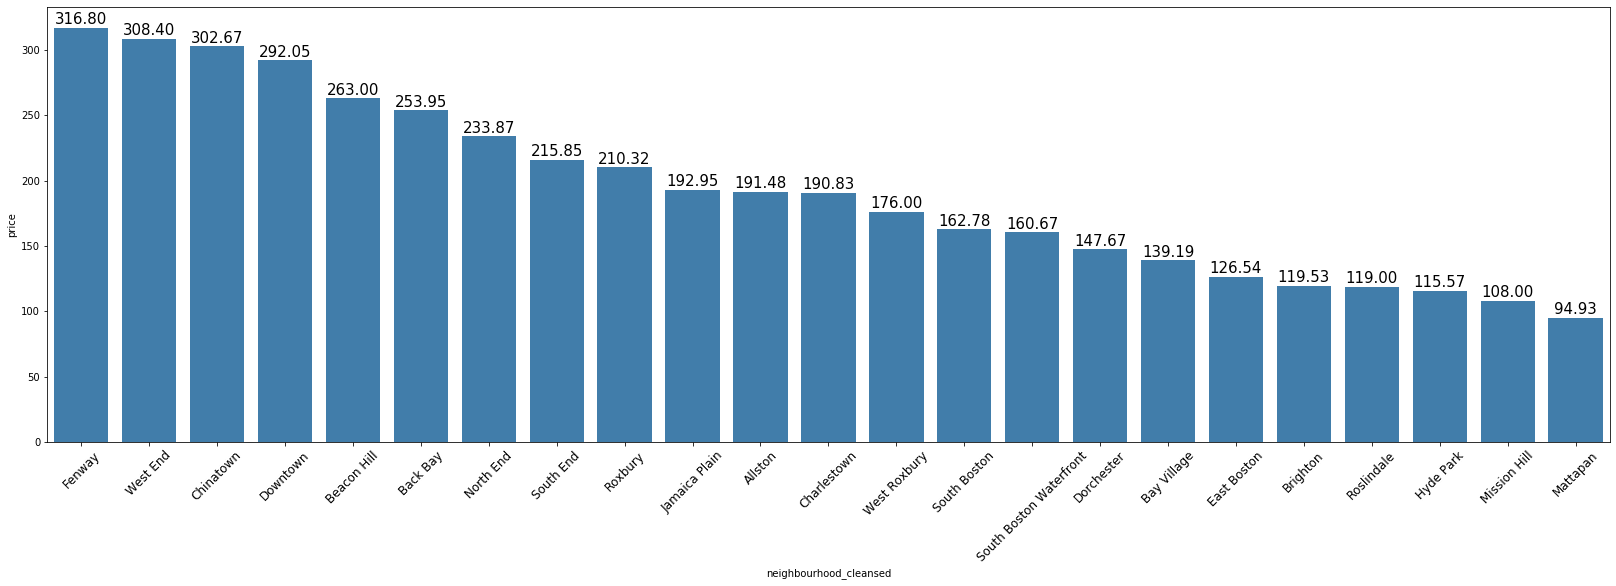

In [21]:
plt.figure(figsize=(28,8))
plots = sns.barplot(
    x='neighbourhood_cleansed', y='price',
    data= new,
    color='#2F7FBC'
)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)

plt.show()

Absolutely, the neighborhood have significantly influence on room price. In the Fenway, the average price of listings is around 317 dollars, which is the most expensive area. The Mattapan area cost around $94 for a room, which is one thrid of price in the Fenway.

### Q3: What’s the best time to visit Boston?

In [22]:
## We use calendar dataset to analyze this issuse, so we also need remove $ for price column and format month column
##remove dollar sign
import re
calendar['price'] = calendar.astype(str).price.apply(
    lambda value: re.sub(r'\$|,', '', value)
).astype(float)
# work with month
calendar["month"] = calendar["date"].str.split("/").str[0]
calendar['month'] = calendar['month'].replace({
    '1': 'Jan',
    '2': 'Feb',
    '3': 'Mar',
    '4': 'Apr',
    '5': 'May',
    '6': 'Jun',
    '7': 'Jul',
    '8': 'Aug',
    '9': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
})
calendar["month"] = calendar["month"].astype('category')
sorter = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
calendar["month"].cat.set_categories(sorter, inplace=True)


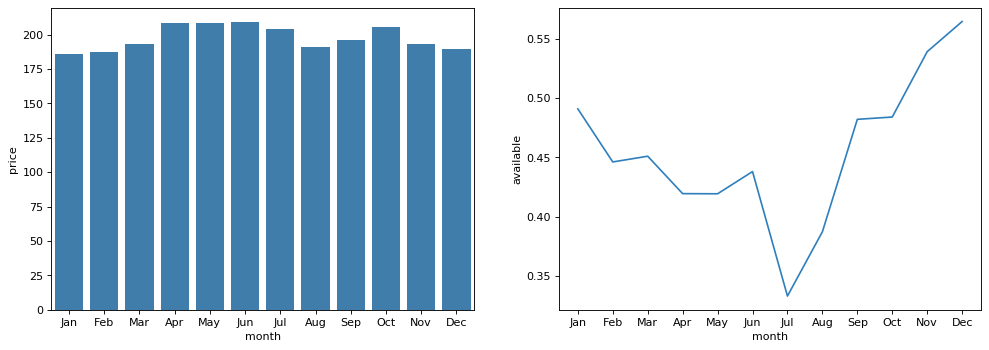

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=80)

month_price = calendar.groupby("month").agg({'price': 'mean'}).reset_index()
sns.barplot(
    x='month', y='price',
    data= month_price,
    color='#2F7FBC',
    ax=axs[0]
)


calendar['available'] = calendar['available'].replace({
    'f': 0,
    't': 1,})
vacancy = calendar.groupby("month").agg({'available': 'mean'}).reset_index()
sns.lineplot(
    x='month', y='available',
    data= vacancy,
    color='#2F7FBC',
    ax=axs[1]
)


We can see the average listing price in Boston does not change too much every month. There are couple of months have a slightly higher average listing price. The listing price is a little higher from the April to October compare to other months. Additionally, the vacancy rate is also low from April to August, especially in July. The best time to visit Boston is from April to October.

# Section 4: Modeling

#### How to estimate the listing room price? 

In [24]:
# Get numeric columns
num_columns = listings_new[["bathrooms_text_number","accommodates","bedrooms","beds","number_of_reviews",
                            "review_scores_rating","review_scores_accuracy","review_scores_cleanliness",
                            "review_scores_checkin","review_scores_communication","review_scores_location",
                            "review_scores_value","reviews_per_month"]]
num_columns.head()

,bathrooms_text_number,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
1,1,2,1.0,1.0,107,4.77,4.87,4.89,4.95,4.89,4.52,4.78,0.90
10,1,2,1.0,1.0,94,4.96,4.95,4.98,5.00,4.97,4.79,4.96,0.72
11,1.5,2,1.0,1.0,80,4.97,4.95,5.00,4.97,4.94,4.91,4.94,0.72
12,1,3,1.0,0.0,130,4.63,4.66,4.76,4.73,4.68,4.81,4.49,0.98
13,1,1,1.0,1.0,141,4.73,4.65,4.58,4.86,4.91,4.13,4.62,1.26


In [25]:
# Get categorical columns
cat_columns = listings_new[["host_response_time","host_is_superhost","neighbourhood_cleansed","room_type",
                            "instant_bookable"]]
cat_columns.head()

,host_response_time,host_is_superhost,neighbourhood_cleansed,room_type,instant_bookable
1,within an hour,t,Roxbury,Entire home/apt,f
10,within a few hours,f,Charlestown,Entire home/apt,f
11,within a few hours,t,Jamaica Plain,Private room,f
12,within a day,t,Charlestown,Entire home/apt,f
13,within an hour,t,Roxbury,Private room,f


In [35]:
#Create a copy of the dataframe
listings_new_copy = listings_new.copy()
#Pull a list of the column names of the categorical variables
#cat_cols_lst = listings_new.columns

def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

create_dummy_df(df, cat_columns, dummy_na=False).head()


,bathrooms_text_number,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,room_type_Hotel room,room_type_Private room,room_type_Shared room,instant_bookable_t
1,1.0,2,1.0,1.0,107,4.77,4.87,4.89,4.95,4.89,...,1,0,0,0,0,0,0,0,0,0
10,1.0,2,1.0,1.0,94,4.96,4.95,4.98,5.00,4.97,...,0,0,0,0,0,0,0,0,0,0
11,1.5,2,1.0,1.0,80,4.97,4.95,5.00,4.97,4.94,...,0,0,0,0,0,0,0,1,0,0
12,1.0,3,1.0,0.0,130,4.63,4.66,4.76,4.73,4.68,...,0,0,0,0,0,0,0,0,0,0
13,1.0,1,1.0,1.0,141,4.73,4.65,4.58,4.86,4.91,...,1,0,0,0,0,0,0,1,0,0


In [28]:
### check categorical columns
cat_df = listings_new.select_dtypes(include=['object'])
cat_df.head()

,listing_url,last_scraped,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,...,room_type,bathrooms_text,amenities,has_availability,calendar_last_scraped,first_review,last_review,license,instant_bookable,bathrooms_text_number
1,https://www.airbnb.com/rooms/5506,2021-07-12,**Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/miso/Hosting-...,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, Massachusetts, United States",...,Entire home/apt,1 bath,"[""Washer"", ""Free street parking"", ""First aid k...",t,2021-07-12,2011-10-23,2020-05-01,Approved by the government,f,1
10,https://www.airbnb.com/rooms/29765,2021-07-12,"Luxury suite, Moroccan furnishings","<b>The space</b><br />Romantic, comfortable, a...",Boston's oldest and most historic neighborhood...,https://a0.muscache.com/pictures/621420/77d899...,https://www.airbnb.com/users/show/128280,Elizabeth,2010-05-19,"Boston, Massachusetts, United States",...,Entire home/apt,1 bath,"[""Lockbox"", ""First aid kit"", ""Fire extinguishe...",t,2021-07-12,2010-10-10,2021-05-09,STR-454024,f,1
11,https://www.airbnb.com/rooms/40601,2021-07-12,Private room & bath - Jamaica Plain,Private bedroom and bathroom in my house in Ja...,Jamaica Plain is a diverse neighborhood of Bos...,https://a0.muscache.com/pictures/508984/678a92...,https://www.airbnb.com/users/show/174986,Robert,2010-07-20,"Boston, Massachusetts, United States",...,Private room,1.5 baths,"[""Toaster"", ""Host greets you"", ""Oven"", ""Washer...",t,2021-07-12,2012-05-11,2021-05-30,STR-408632,f,1.5
12,https://www.airbnb.com/rooms/45987,2021-07-12,Gorgeous Garden Studio Charlestown,"<b>The space</b><br />Lovely, private garden s...",Historical and safe.,https://a0.muscache.com/pictures/261758/678964...,https://www.airbnb.com/users/show/205107,Atef,2010-08-18,"Boston, Massachusetts, United States",...,Entire home/apt,1 bath,"[""Washer"", ""Air conditioning"", ""Smoke alarm"", ...",t,2021-07-12,2010-08-30,2019-12-10,STR-409822,f,1
13,https://www.airbnb.com/rooms/60029,2021-07-12,Room in geographical heart of Hub,"Small, sunny, private room in quiet but urban ...","Architecturally interesting, historic (Roxbury...",https://a0.muscache.com/pictures/3bf41756-488c...,https://www.airbnb.com/users/show/255183,Michelle,2010-10-06,"Boston, Massachusetts, United States",...,Private room,1 shared bath,"[""Hot water"", ""Refrigerator"", ""Host greets you...",t,2021-07-12,2012-04-21,2019-08-13,STR-415714,f,1


In [30]:
## change the bathroom data type to float
listings_new["bathrooms_text_number"] = listings_new["bathrooms_text_number"].astype(float)

In [31]:
# create a new data set to test model
df  = listings_new[["bathrooms_text_number","accommodates","bedrooms","beds","number_of_reviews",
                    "review_scores_rating","review_scores_accuracy","review_scores_cleanliness",
                    "review_scores_checkin","review_scores_communication",
                    "review_scores_location","review_scores_value","reviews_per_month",
                    "host_response_time","host_is_superhost","neighbourhood_cleansed",
                    "room_type","instant_bookable","price"
                   ]]

#Pull a list of the column names of the categorical variables
cat_cols_lst = cat_columns

# get dummy variables for categorical columns
df_new = create_dummy_df(df, cat_cols_lst, dummy_na=False) #Use your newly created function

# Show a header of df_new to check
df_new.head()

,bathrooms_text_number,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,room_type_Hotel room,room_type_Private room,room_type_Shared room,instant_bookable_t
1,1.0,2,1.0,1.0,107,4.77,4.87,4.89,4.95,4.89,...,1,0,0,0,0,0,0,0,0,0
10,1.0,2,1.0,1.0,94,4.96,4.95,4.98,5.00,4.97,...,0,0,0,0,0,0,0,0,0,0
11,1.5,2,1.0,1.0,80,4.97,4.95,5.00,4.97,4.94,...,0,0,0,0,0,0,0,1,0,0
12,1.0,3,1.0,0.0,130,4.63,4.66,4.76,4.73,4.68,...,0,0,0,0,0,0,0,0,0,0
13,1.0,1,1.0,1.0,141,4.73,4.65,4.58,4.86,4.91,...,1,0,0,0,0,0,0,1,0,0


In [32]:
#Split your data into an X matrix and a response vector y
X = df_new.drop('price', axis=1)
y = df_new['price']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
    
#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [34]:
print(test_score)
print(train_score)

0.5793742945761544
0.7622677694973752
